<a href="https://colab.research.google.com/github/mthangit/CTDL_GT/blob/main/Model/FEDformer/NVL_FEDformer_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 

In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset


In [3]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv('NVL-Historical-Data.csv')

In [5]:
df1 = df

In [6]:

df1['unique_id'] = 'NVL'
df1

,Date,Price,unique_id
0,2017-01-03,25055.00,NVL
1,2017-01-04,25225.00,NVL
2,2017-01-05,25097.00,NVL
3,2017-01-06,25140.00,NVL
4,2017-01-07,25129.25,NVL
...,...,...,...
2702,2024-05-28,14500.00,NVL
2703,2024-05-29,14150.00,NVL
2704,2024-05-30,14150.00,NVL
2705,2024-05-31,14450.00,NVL


In [7]:
df1 = df1[['unique_id', 'Date', 'Price']]
df1

,unique_id,Date,Price
0,NVL,2017-01-03,25055.00
1,NVL,2017-01-04,25225.00
2,NVL,2017-01-05,25097.00
3,NVL,2017-01-06,25140.00
4,NVL,2017-01-07,25129.25
...,...,...,...
2702,NVL,2024-05-28,14500.00
2703,NVL,2024-05-29,14150.00
2704,NVL,2024-05-30,14150.00
2705,NVL,2024-05-31,14450.00


In [8]:
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df1

,unique_id,ds,y
0,NVL,2017-01-03,25055.00
1,NVL,2017-01-04,25225.00
2,NVL,2017-01-05,25097.00
3,NVL,2017-01-06,25140.00
4,NVL,2017-01-07,25129.25
...,...,...,...
2702,NVL,2024-05-28,14500.00
2703,NVL,2024-05-29,14150.00
2704,NVL,2024-05-30,14150.00
2705,NVL,2024-05-31,14450.00


In [9]:
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].astype(float)


In [10]:

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2707 entries, 0 to 2706
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2707 non-null   object        
 1   ds         2707 non-null   datetime64[ns]
 2   y          2707 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 63.6+ KB


In [23]:
size = int(len(df1))

In [24]:
train_data = df1[:int(0.8 *size)]
test_data = df1[int(0.8 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 2165
Test lenght: 542


In [25]:
train_data

,unique_id,ds,y
0,NVL,2017-01-03,25055.00
1,NVL,2017-01-04,25225.00
2,NVL,2017-01-05,25097.00
3,NVL,2017-01-06,25140.00
4,NVL,2017-01-07,25129.25
...,...,...,...
2160,NVL,2022-12-03,22560.00
2161,NVL,2022-12-04,22560.00
2162,NVL,2022-12-05,22150.00
2163,NVL,2022-12-06,20600.00


In [26]:
model = FEDformer(h=test_len+90,
                 input_size=100,
                 modes=64,
                 hidden_size=128,
                 n_head=8,
                 loss=MAE(),
                 scaler_type='standard',
                 learning_rate=1e-3,
                 max_steps=200,
                 batch_size=32,
                 windows_batch_size=256,
                )

nf = NeuralForecast(
    models=[model],
    freq='D',
)
nf.fit(df=train_data, static_df=None, verbose=True)


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 251 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.


In [27]:
forecasts = nf.predict(df=test_data)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [28]:
train = train_data['y']
test = test_data['y']

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [29]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100)
print("Root Mean Square Error (RMSE):", rmse)


Mean Absolute Error (MAE): 6816.4697601956495
Mean Absolute Percentage Error (MAPE): 44.83349326758893
Root Mean Square Error (RMSE): 9188.553339991468


In [31]:
# prompt: adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)


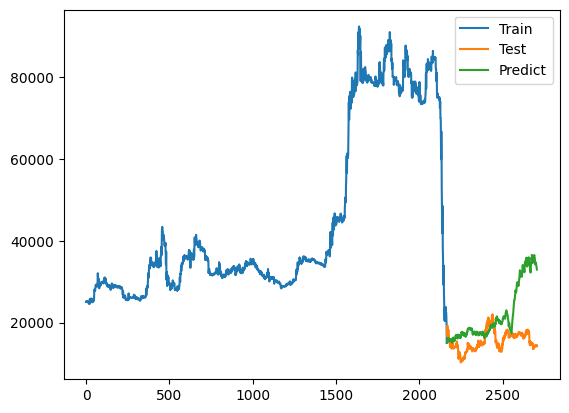

In [32]:
train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)
predict_test_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(predict_test_index,(predict_test))
plt.legend(['Train','Test','Predict'])
plt.show()



In [33]:
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]


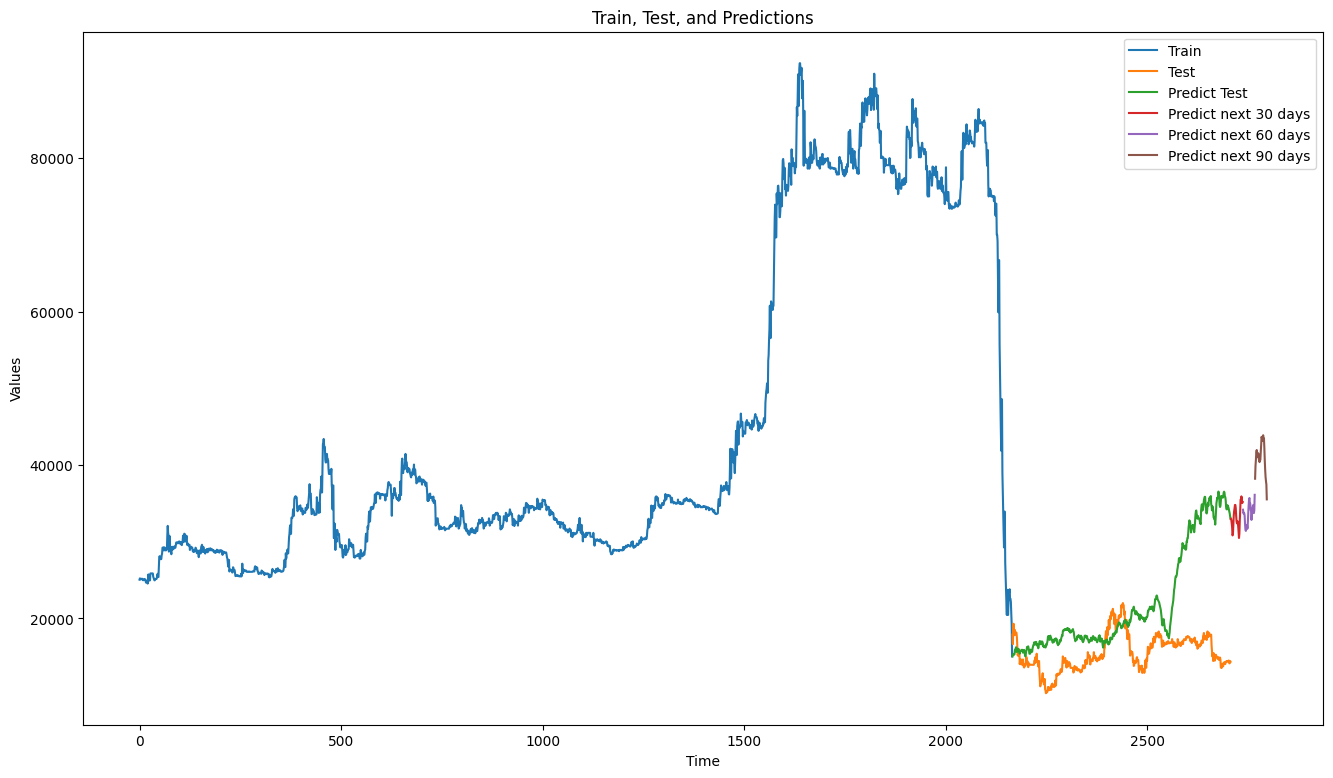

In [34]:
plt.figure(figsize=(16, 9))
train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)
predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))
predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)
plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Train, Test, and Predictions')
plt.show()
